Notebook for adversarial training

Actually, "adversarial" might not be the best word here as IPDs are not zero-summed.

This notebook expects them to learn to cooperate with each other to achieve the most profits for themselves.

In [1]:
%load_ext autoreload
%autoreload 2

import gc
import dill
import numpy as np
import pandas as pd
import axelrod as axl
from time import time
from copy import deepcopy
from pprint import pprint
from itertools import groupby, permutations

np.set_printoptions(precision=3)

# the following imports are from network / axl_utils folder
import network
from network.dqn import DQN
from network.replay import ReplayMemory
from axl_utils.nnplayer import NNplayer, State, train
from axl_utils.game import set_match, set_play

In [2]:
GAME_LEN = 20 + 1
C = axl.Action.C
D = axl.Action.D
Match = set_match(game=axl.Game(r=3, s=0, t=5, p=1), turns=GAME_LEN)
play = set_play(Match)

In [3]:
dqn = DQN([
                    network.Flatten_layer(),
                    network.Linear_layer(GAME_LEN*2, 100, bias=0.01),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(100, 200),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(200, 100),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(100, 40),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(40, 2),
                    ])
p1 = NNplayer(deepcopy(dqn), ReplayMemory(4000), State(GAME_LEN), gamma=0.9)
dqn.reset()
p2 = NNplayer(deepcopy(dqn), ReplayMemory(4000), State(GAME_LEN), gamma=0.9)
del dqn
gc.collect()

param = {"lr": 1e-5, 'batch': 16, "momentum": 0.9, "mode": "train", "eps": 1e-16, "beta":(0.9, 0.999), 
         "epoch": 0, 'optimizer': 'adam', 't': 1, 'clip': 1.0, 'decay': 0.0}

Network reinitialized.


In [4]:
game = play(p1, p2)

[(5, 0), (3, 3), (3, 3), (3, 3), (5, 0), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (5, 0), (3, 3), (3, 3), (3, 3), (3, 3), (0, 5), (0, 5), (3, 3), (3, 3)]
Player 1 score = 60
Player 2 score = 55


In [5]:
import distutils.cygwinccompiler
distutils.cygwinccompiler.get_msvcr = lambda: []

# Start training

following data is collected:

p1 loss C, p1 loss D, p2 loss C, p2 loss D

p1 score, p2 score, num of CC, # DD, # CD, # DD, max consecutive not-DD turns, 

match history

In [5]:
[Match((p1, p2)).play() for _ in range(40)]

ls = []
match_ls = []
for i in range(200):
    
    print(f'--------Iter {i}--------')
    start = time()
    
    # get experience
    [Match((p1, p2)).play() for _ in range(20)]
    
    # test strategy
    p1.greedy = p2.greedy = 0
    game = play(p1, p2)
    actions = game.play()
    scores = game.scores()
    p1.greedy = p2.greedy = 0.2
    
    # scores
    # again we remove the last turn because it is just a buffer
    p1s = sum(list(zip(*scores))[0][:-1])
    p2s = sum(list(zip(*scores))[1][:-1])
    ssum = p1s + p2s
    sdif = p1s - p2s
    
    # count interactions
    cc = sum([act == (C,C) for act in game.result[:-1]])
    dd = sum([act == (D,D) for act in game.result[:-1]])
    cd = sum([act == (C,D) for act in game.result[:-1]])
    dc = sum([act == (D,C) for act in game.result[:-1]])
    
    # count longest consecutive non-DD actions and CCs
    try:
        ndds = max(map(len, [list(actions) for is_dd, actions in groupby(game.result[:-1], lambda x: x == (D,D)) if not is_dd]))
    except ValueError:
        ndds = 0
    try:
        ccs  = max(map(len, [list(actions) for is_cc, actions in groupby(game.result[:-1], lambda x: x == (C,C)) if is_cc]))
    except ValueError:
        ccs  = 0
    
    # train
    print("--------training p1--------")
    train(p1, 10, param)
    print(p1.loss)
    print("--------training p2--------")
    train(p2, 10, param)
    print(p2.loss)
    
    # record training loss
    p1c = p1.loss[0]
    p1d = p1.loss[1]
    p2c = p2.loss[0]
    p2d = p2.loss[1]
    
    # save
    ls.append((p1c, p1d, p2c, p2d, p1s, p2s, ssum, sdif, cc, dd, cd, dc, ndds, ccs))
    match_ls.append(game.result)
    
    param['lr'] *= 0.99
    print(f"+ {time() - start} sec")

--------Iter 0--------
[(0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (1, 1), (0, 5), (0, 5), (0, 5), (1, 1), (1, 1), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5)]
Player 1 score = 3
Player 2 score = 88
--------training p1--------
[0.38  0.644]
--------training p2--------
[0.239 0.755]
--------Iter 1--------
[(1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1)]
Player 1 score = 20
Player 2 score = 20
--------training p1--------
[0.321 0.493]
--------training p2--------
[0.908 1.259]
--------Iter 2--------
[(1, 1), (0, 5), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (5, 0), (3, 3), (1, 1), (1, 1), (1, 1), (1, 1), (3, 3), (0, 5), (0, 5), (0, 5), (5, 0), (5, 0), (3, 3)]
Player 1 score = 34
Player 2 score = 39
--------training p1--------
[0.341 0.49 ]
--------training p2--------


KeyboardInterrupt: 

In [ ]:
data = pd.DataFrame(ls, 
             columns=['p1 loss C', 'p1 loss D', 'p2 loss C', 'p2 loss D', 'p1 score', 'p2 score', 'score sum', 'score diff', 'CC', 'DD', 'CD', 'DC', 'longest consecutive not-DD turns', 'longest consecutive CC turns'])

In [ ]:
data

In [ ]:
data.to_csv('data/data.csv')

In [ ]:
with open('data/history.pkl', "wb") as file:
    dill.dump(match_ls, file)
    
with open('data/p1.pkl', "wb") as file:
    dill.dump(p1, file)
    
with open('data/p2.pkl', "wb") as file:
    dill.dump(p2, file)

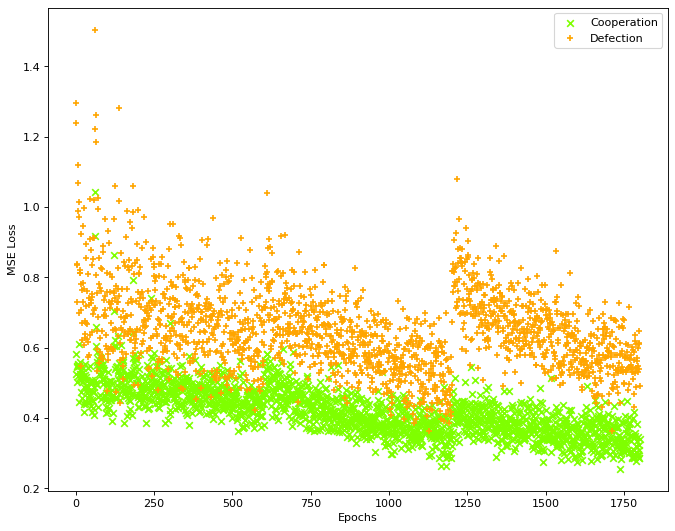

In [6]:
p1.plot()

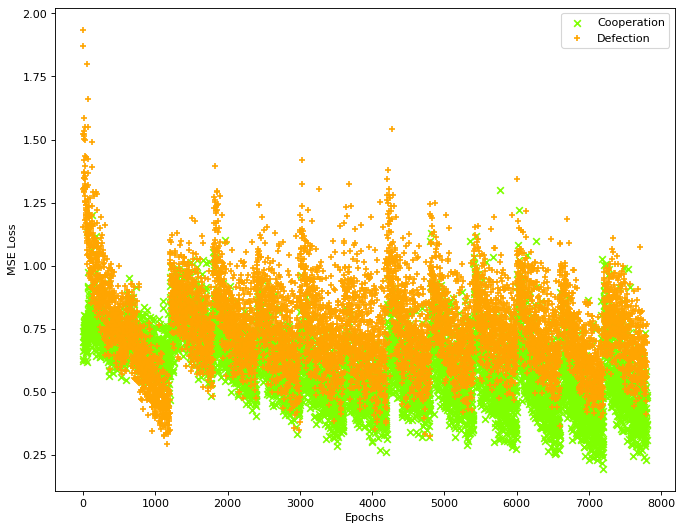

In [7]:
p2.plot()

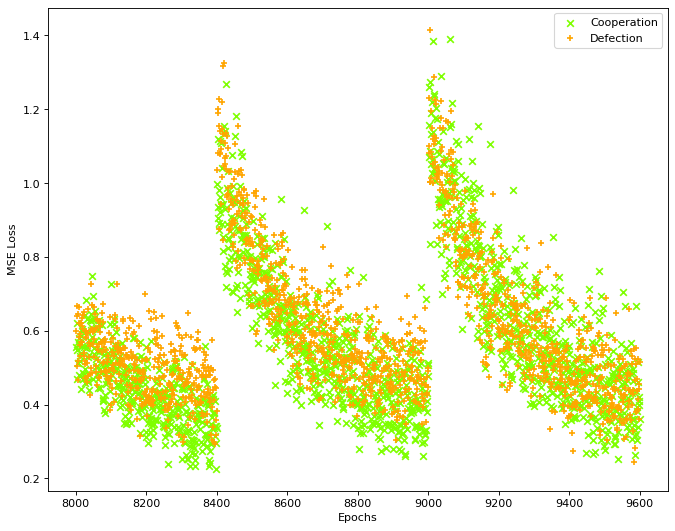

In [86]:
p2.plot(min_ran=8000, max_ran=9600)